# 无监督学习——多元分析

传统的多元分析包括：主成分分析、因子分子、聚类分析、典型相关分析、判别分析
由于**没有目标变量或者因变量**，多元分析是无监督学习。因此，多元分析没有一个诸如预测精度之类的优劣标准，任何文献中提出的所谓的标准都是对显示世界的数据做出主观假定后才发现的，不属于科学的范畴。
当多个指标阐释一个对象时，我们必须把多个指标的各个方面进行高度概括，用一两个指标简洁明了的说明白情况。在如此多的变量之中，我们希望找出他们的“少数代表”来对他们进行描述，也就是需要**降低变量的维数**。 

但是： 
 
->降维必定损失信息 
 
->如果数据之间相互独立，降维是不可能的

In [1]:
import math
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import graphviz

# 用于创建一个具有默认值的字典
from collections import defaultdict
# 方便地在Jupyter Notebook或IPython环境中呈现和交互式操作SVG图像
from IPython.display import SVG

import statsmodels as tsm
import matplotlib as tplt
import sklearn as tsk

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans,AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram,linkage,set_link_color_palette
from sklearn.cross_decomposition import CCA
from scipy.stats import pearsonr


# 主成分分析-Principle competent analysis

In [2]:
who = pd.read_csv("../data/who.txt")
who

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10
Algeria,6,5940,94,96,1.5,64,24,7,29,2.4
Angola,146,3890,49,51,2.8,54,17,4,46,6.5
Benin,108,1250,73,87,3.1,40,18,4,44,5.6
Botswana,51,11730,85,83,1.2,58,21,5,35,3.0
Burkina Faso,131,1130,42,52,3.0,19,17,4,46,6.1
...,...,...,...,...,...,...,...,...,...,...
Singapore,7,43300,77,77,1.3,100,38,13,19,1.3
Solomon Islands,72,1850,61,62,2.4,17,20,5,40,4.0
Tonga,17,5470,94,97,0.5,24,21,9,37,3.8
Vanuatu,92,3480,86,88,2.5,24,20,5,39,3.9


In [3]:
eigen_val,eigen_vec = np.linalg.eig(np.corrcoef(who.T))
eigen_val_ratio = eigen_val / np.sum(eigen_val) 
eigen_val_ration_cusum = np.cumsum(eigen_val_ratio)
eigen = pd.DataFrame({'特征值': eigen_val, '特征向量': eigen_val_ratio, '特征值累计比例': eigen_val_ration_cusum})
print(eigen)

        特征值      特征向量   特征值累计比例
0  6.718991  0.671899  0.671899
1  1.153588  0.115359  0.787258
2  0.883543  0.088354  0.875612
3  0.467350  0.046735  0.922347
4  0.429856  0.042986  0.965333
5  0.170309  0.017031  0.982364
6  0.110558  0.011056  0.993419
7  0.005216  0.000522  0.993941
8  0.027010  0.002701  0.996642
9  0.033579  0.003358  1.000000


Text(0, 0.5, 'Cumulative Eigen value(ratio)')

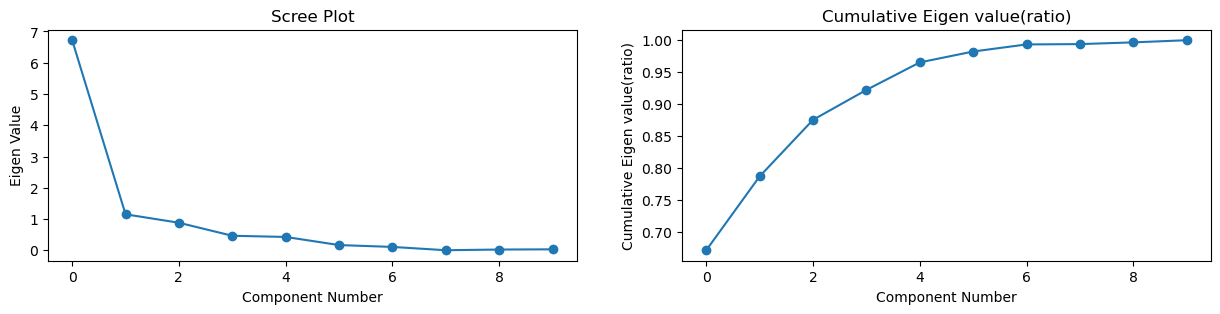

In [5]:
fig = plt.figure(figsize=(15,3))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(eigen_val)
ax1.scatter(range(len(eigen_val)),eigen_val)
ax1.set_title("Scree Plot")
ax1.set_xlabel('Component Number')
ax1.set_ylabel('Eigen Value')

ax1 = fig.add_subplot(1, 2, 2)
ax1.plot(eigen_val_ration_cusum)
ax1.scatter(range(len(eigen_val_ration_cusum)), eigen_val_ration_cusum)
ax1.set_title("Cumulative Eigen value(ratio)")
ax1.set_xlabel('Component Number')
ax1.set_ylabel('Cumulative Eigen value(ratio)')


对who数据进行主成分分析，并产生碎石图和累积特征值图。结合上面两幅图可知，当聚类数为3或5是，聚类效果最佳，可解释性最强，因为累计特征已经达到了90%以上。聚类肯定会有数据的损失，所以找出损失最小的聚类结果代表总体效果最佳。

In [7]:
component_matrix = pd.DataFrame(np.round(-eigen_vec*np.sqrt(eigen_val),2))
component_matrix.index = [f'x{i}' for i in range(1,len(eigen_val)+1)]
component_matrix.columns = list(range(1,len(eigen_val) + 1))
component_matrix

,1,2,3,4,5,6,7,8,9,10
x1,0.80,0.06,0.01,0.57,-0.14,0.14,-0.08,0.00,0.00,-0.00
x2,-0.72,-0.31,-0.48,0.08,0.31,0.21,0.09,0.00,-0.01,-0.00
x3,-0.74,0.64,-0.16,0.06,0.01,-0.00,0.02,0.00,0.08,0.10
x4,-0.71,0.66,-0.18,0.10,0.06,-0.06,-0.00,-0.00,-0.07,-0.10
x5,0.80,-0.00,-0.51,-0.08,0.18,-0.10,-0.22,0.00,-0.02,0.03
x6,-0.66,-0.28,-0.51,0.04,-0.47,-0.10,0.03,0.00,0.00,-0.00
x7,-0.95,-0.22,0.09,0.11,0.09,-0.05,-0.10,-0.05,0.05,-0.03
x8,-0.86,-0.24,0.19,0.29,0.15,-0.20,0.01,0.02,-0.06,0.07
x9,0.97,0.13,-0.13,0.02,-0.01,-0.03,0.15,-0.05,-0.06,0.06
x10,0.92,-0.07,-0.15,0.16,0.17,-0.20,0.12,0.01,0.08,-0.06


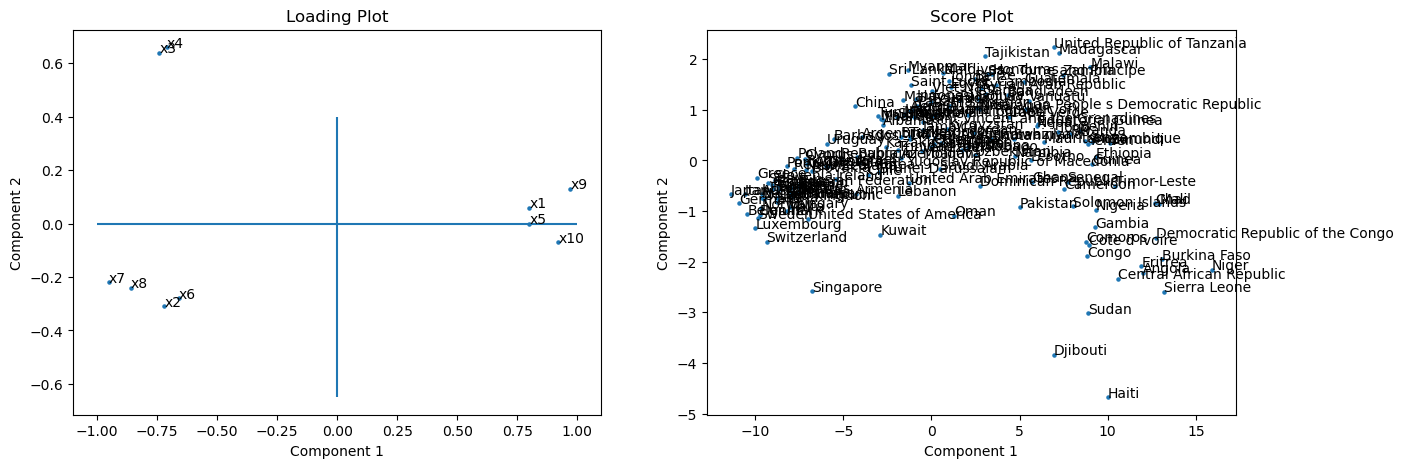

In [11]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,2,1)
ax1.scatter(component_matrix.iloc[:,0],component_matrix.iloc[:,1],s=5)
for x,y,z in zip(component_matrix.iloc[:,0],component_matrix.iloc[:,1],component_matrix.index):
    ax1.text(x,y,z)
ax1.set_title("Loading Plot")
ax1.set_xlabel('Component 1')
ax1.set_ylabel('Component 2')
ax1.hlines(0,-1,1)
ax1.vlines(0,-0.65,0.4)


who_std = StandardScaler().fit_transform(who)
score = who_std.dot(component_matrix.iloc[:,:2])
ax2 = fig.add_subplot(1,2,2)
ax2.scatter(score[:,0],score[:,1],s=5)
ax2.set_title("Score Plot")
ax2.set_xlabel('Component 1')
ax2.set_ylabel('Component 2')
for x,y,z in zip(score[:,0],score[:,1],who.index):
    ax2.text(x,y,z)

# 聚类分析案例-cluster analysis case study

聚类效果的优劣没有统一标准的衡量指标，完全依照用户的意图而定。
物以类聚、人以群分,分类的根据是什么呢？
有人根据观测值对变量的分类为R型聚类，而按照变量对观测值的分类叫做Q型分类。

主要的聚类方法有：
 
1.KMeans(K均值聚类)/快速聚类->事先要求好划分的类数作为“聚类种子数”，有算法自动计算划分 

2.分层聚类(事先不知道有多少层)->一棵树，自底向上归类，有种哈夫曼编码的感觉。

聚类的本质：**距离** 
数据最简单的分类就是根据一个指标进行分类，这些数据在直线上形成了许多点，这样就可以直线上的距离近得点放到一起。如果再次加入一个变量，数据有一维空间拓展到了二维空间，那么也可以按照直线距离的远近大小来进行分类。三维或者高维数据的情况也是类似的，只不过三维以及高维数据我们无法直观地可视化表示。 
 
1.欧式距离计算法：
$$d(\mathbf{p}, \mathbf{q}) = \sqrt{\sum_{i=1}^{n}(p_i - q_i)^2}$$ 
2.曼哈顿距离Manhattan Distance）: 
$$d(\mathbf{p}, \mathbf{q}) = \sum_{i=1}^{n}|p_i - q_i|$$ 
3.闵可夫斯基距离（Minkowski Distance）: 
$$d(\mathbf{p}, \mathbf{q}) = \left(\sum_{i=1}^{n}|p_i - q_i|^p\right)^{\frac{1}{p}}$$ 
其中，$\mathbf{p}$ 和 $\mathbf{q}$ 是个向量，$p_{i}$ 和 $q_{i}$ 是向量中的元素，$v$ 是向量的维度，$p$ 是闵夫斯基距离的参数。



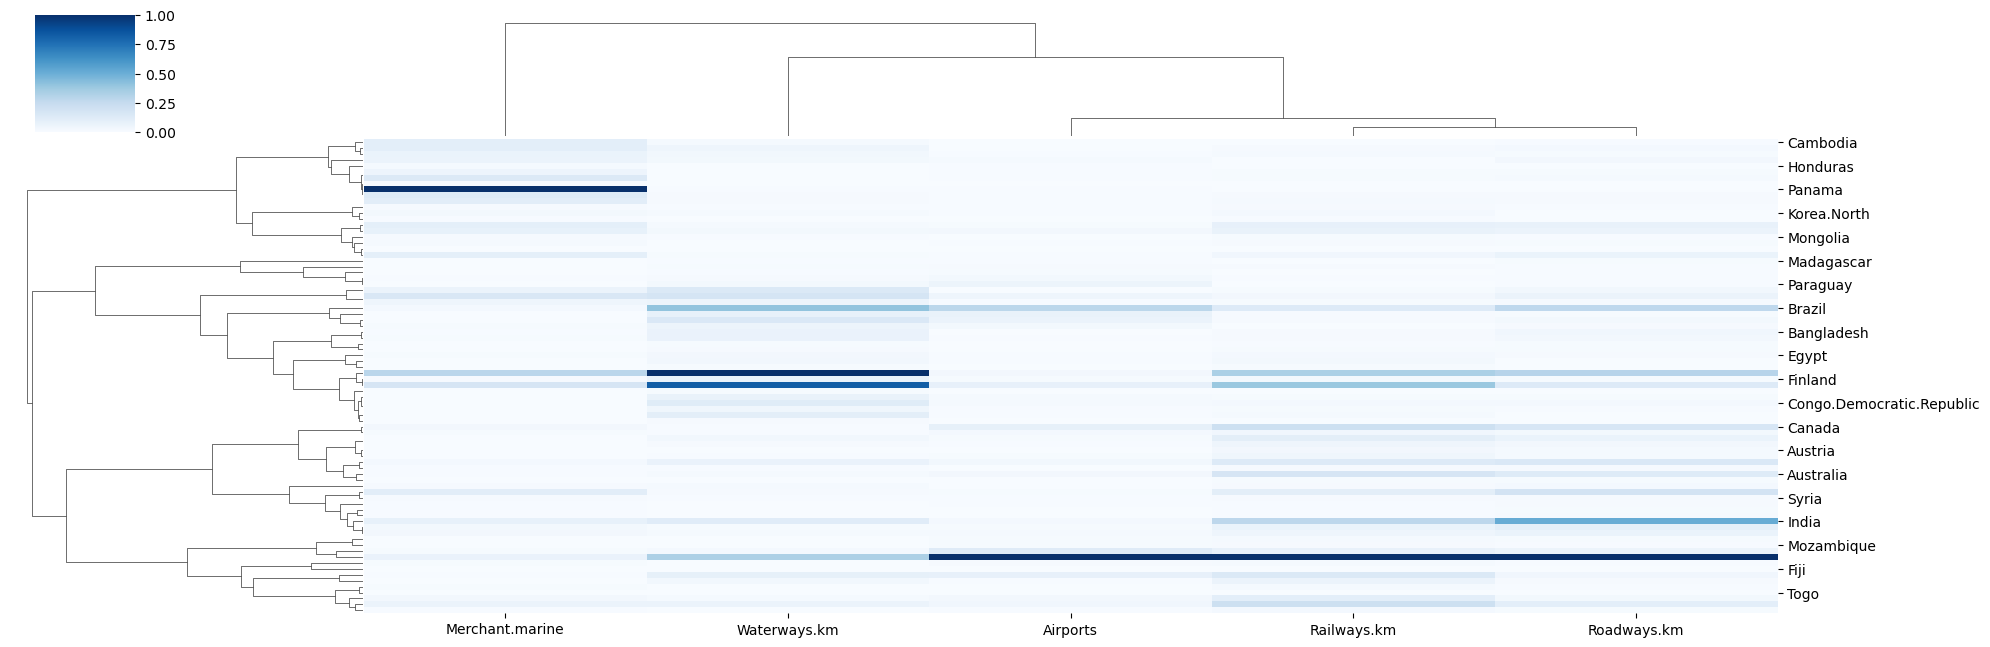

In [10]:
trans = pd.read_csv("../data/trans.txt",sep='\s+')
sns.clustermap(trans,metric="correlation",method="complete",cmap="Blues",figsize=(20,6.5),standard_scale=1)

交通数据的分成聚类

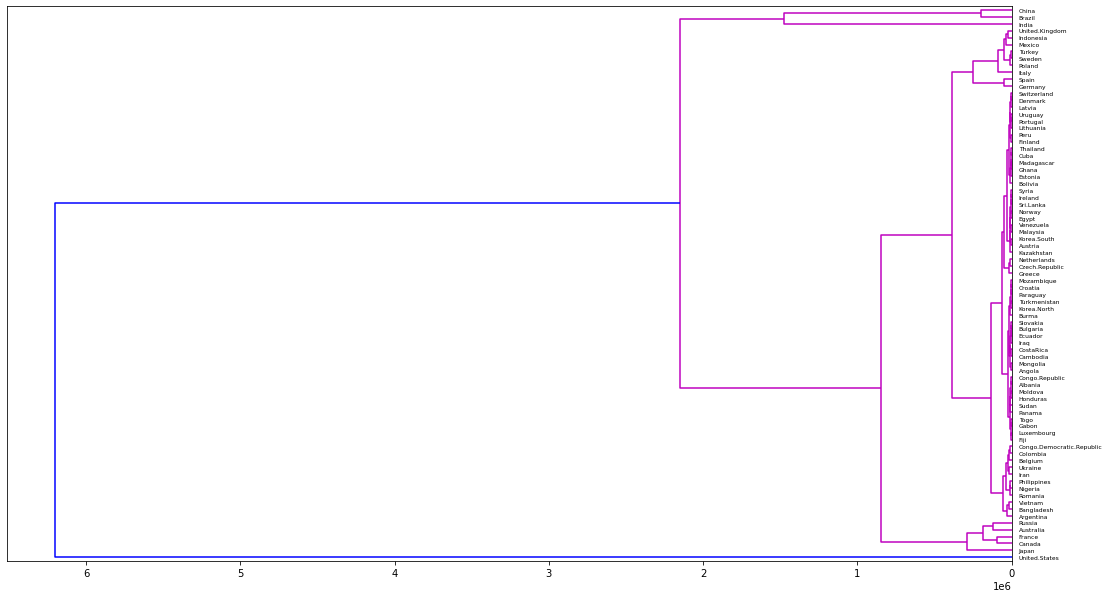

In [8]:
Z  =linkage(trans,method="average",metric='euclidean')
set_link_color_palette(['m','c','y','k'])
fig = plt.figure(figsize=(18,10),dpi=72)
dendrogram(Z,labels=trans.index,leaf_rotation=0,orientation="left",leaf_font_size=6,color_threshold=None,above_threshold_color='blue')
set_link_color_palette(None)

大城市建筑数据聚类

In [20]:
trans1 = pd.read_csv("../data/cities0.txt", encoding='latin-1')
trans1

,Population,Area,Buildings,Points
Hong Kong,6787000,1001,7445,115102
New York City,8104079,800,5455,35611
Seoul,10331244,616,2839,15850
Chicago,2862244,589,1045,15463
Singapore,3437300,685,3503,13147
...,...,...,...,...
Mississauga,612925,288,202,582
Nagoya,2171378,326,163,574
Cleveland,458684,201,120,554
Charlotte,594359,451,54,554


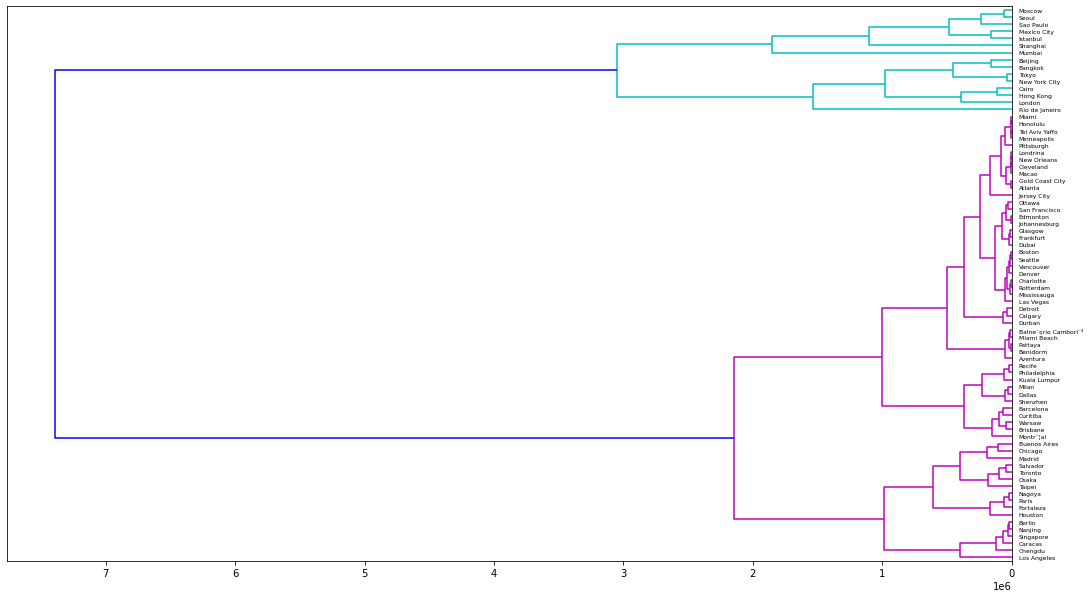

In [21]:
Z = linkage(trans1, method="average", metric='euclidean')
set_link_color_palette(['m', 'c', 'y', 'k'])
fig = plt.figure(figsize=(18, 10), dpi=72)
dendrogram(Z, labels=list(trans1.index), leaf_rotation=0, orientation="left",
           leaf_font_size=6, color_threshold=None, above_threshold_color='blue')
set_link_color_palette(None)


**聚类之前目标一定要明确，因为聚类的结果主要收到所选择的变量的影响，如果去掉一些变量或者增加一些变量结果会不同。**

# 典型相关分析 classic relation analysis